In [ ]:
from pydub import AudioSegment
import os
from tqdm import tqdm
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import h5py

In [ ]:
class Split_Audio:
  def __init__(self, folder_path, folder_path_processed):
    self.folder_path = folder_path
    self.folder_path_processed = folder_path_processed
    if not os.path.exists(self.folder_path):
      raise FileNotFoundError(f"Thư mục {self.folder_path} không tồn tại.")
    os.makedirs(self.folder_path_processed, exist_ok=True)
    self.list_dir = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
  def split_audio(self):
    if not self.list_dir:
      print("Không tìm thấy file .wav nào trong thư mục.")
      return
    for file_name in tqdm(self.list_dir, desc="Đang tải dữ liệu"):
      file_path = os.path.join(self.folder_path, file_name)
      audio = AudioSegment.from_wav(file_path)
      segment_duration = 3 * 1000
      total_segments = len(audio) // segment_duration
      if total_segments == 0:
        print(f"Bỏ qua {file_name} vì quá ngắn (< 3s).")
        continue
      for i in tqdm(range(total_segments), desc=f"  -> Cắt {file_name}", leave=False):
        start_time = i * segment_duration
        end_time = start_time + segment_duration
        chunk = audio[start_time : end_time]
        chunk_name = f"{os.path.splitext(file_name)[0]}_chunk_{i}.wav"
        chunk.export(os.path.join(self.folder_path_processed, chunk_name), format="wav")
    print("Done")

In [ ]:
def preprocess_audio(filepath, target_sr=22050, n_fft=2048, win_length=1024, hop_length=512, n_mels=128, normalize=False):
    audio, sr = sf.read(filepath, dtype="float32")

    # Chuyển stereo thành mono nếu cần
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)  # axis=1 để lấy trung bình theo kênh

    # Resample nếu tần số không đúng
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # Chuẩn hóa tín hiệu [-1, 1]
    if np.max(np.abs(audio)) > 0:
        audio = audio / np.max(np.abs(audio))

    # Tính STFT
    stft = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length))

    # Chuyển sang Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(S=stft, sr=sr, n_mels=n_mels)

    # Áp dụng log transform
    mel_compressed = np.log1p(mel_spectrogram)

    # Chuẩn hóa về [0, 1] nếu cần
    if normalize and np.max(mel_compressed) > 0:
        mel_compressed /= np.max(mel_compressed)

    return mel_compressed

In [ ]:
class Process_Audio:
  def __init__(self, folder_path, file_name_out, target_sr=22050, n_fft=2048, win_length=1024, hop_length=512, n_mels=128, normalize=False):
    self.folder_path = folder_path
    self.file_name_out = file_name_out
    self.target_sr = target_sr
    self.n_fft = n_fft
    self.win_length = win_length
    self.hop_length = hop_length
    self.n_mels = n_mels
    self.normalize = normalize
    self.list_dir = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

  def process(self):
    if not self.list_dir:
      print("Không tìm thấy file .wav nào trong thư mục.")
    with h5py.File(self.file_name_out, "w") as hf:
      for i, file_name in tqdm(enumerate(self.list_dir), total=len(self.list_dir), desc="Đang tải dữ liệu"):
        filepath = os.path.join(self.folder_path, file_name)
        audio, sr = sf.read(filepath, dtype="float32")

        # Chuyển stereo thành mono nếu cần
        if audio.ndim > 1:
            audio = np.mean(audio, axis=1)  # axis=1 để lấy trung bình theo kênh

        # Resample nếu tần số không đúng
        if sr != self.target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=self.target_sr)
            sr = self.target_sr

        # Chuẩn hóa tín hiệu [-1, 1]
        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio))

        # Tính STFT
        stft = np.abs(librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length, win_length=self.win_length))

        # Chuyển sang Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(S=stft, sr=sr, n_mels=self.n_mels)

        # Áp dụng log transform
        mel_spec = np.log1p(mel_spec)

        # Chuẩn hóa về [0, 1] nếu cần
        if self.normalize and np.max(mel_spec) > 0:
            mel_spec /= np.max(mel_spec)

        if mel_spec.shape[1] < 130:
            mel_spec = np.pad(mel_spec, ((0, 0), (0, 130 - mel_spec.shape[1])), mode="constant")

        mel_spec = mel_spec[:, :130]

        hf.create_dataset(f"mel_spec_sao_{i}", data=mel_spec)

      print(f"Đã lưu HDF5: {self.file_name_out}")

In [ ]:
folder_path = f"/content/drive/MyDrive/ML_datasets/mel_spectrogram"
file_path_sao = f"mel_spectrogram_sao_final.h5"
file_path_saxo = f"mel_spectrogram_saxo_final.h5"
file_path_guitar = f"mel_spectrogram_guitar_final.h5"
file_path_violin = f"mel_spectrogram_violin_final.h5"
file_path_trong = f"mel_spectrogram_trong_final.h5"
file_path_trumpet = f"mel_spectrogram_trumpet_final.h5"
file_path_piano = f"mel_spectrogram_piano_final.h5"
file_path_list = [file_path_sao, file_path_saxo, file_path_guitar, file_path_violin, file_path_trong, file_path_trumpet, file_path_piano]

In [ ]:
def value_mel_spectrogram(file_path, folder_path=folder_path):
  path = os.path.join(folder_path, file_path)
  with h5py.File(path, "r") as hf:
    keys = list(hf.keys())[:5]
    mel_specs = []
    for key in keys:
      mel_spec = hf[key][:]
      mel_specs.append(mel_spec)
    return mel_specs

In [ ]:
instruments = ['Sáo', 'Saxophone', 'Guitar', 'Violin', 'Trống', 'Trumpet', 'Piano']
mel_specs = [value_mel_spectrogram(file_path) for file_path in file_path_list]

In [ ]:
def visualize_mel_spectrograms(mel_spectrograms, instruments, sr=22050):
    plt.figure(figsize=(15, 12))

    for i in range(len(instruments)):
        plt.subplot(4, 2, i+1)
        librosa.display.specshow(mel_spectrograms[i][2], x_axis="time", y_axis="mel", sr=sr)
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"Mel Spectrogram: {instruments[i]}")
        plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/ML_datasets/image_visualize")
    plt.show()

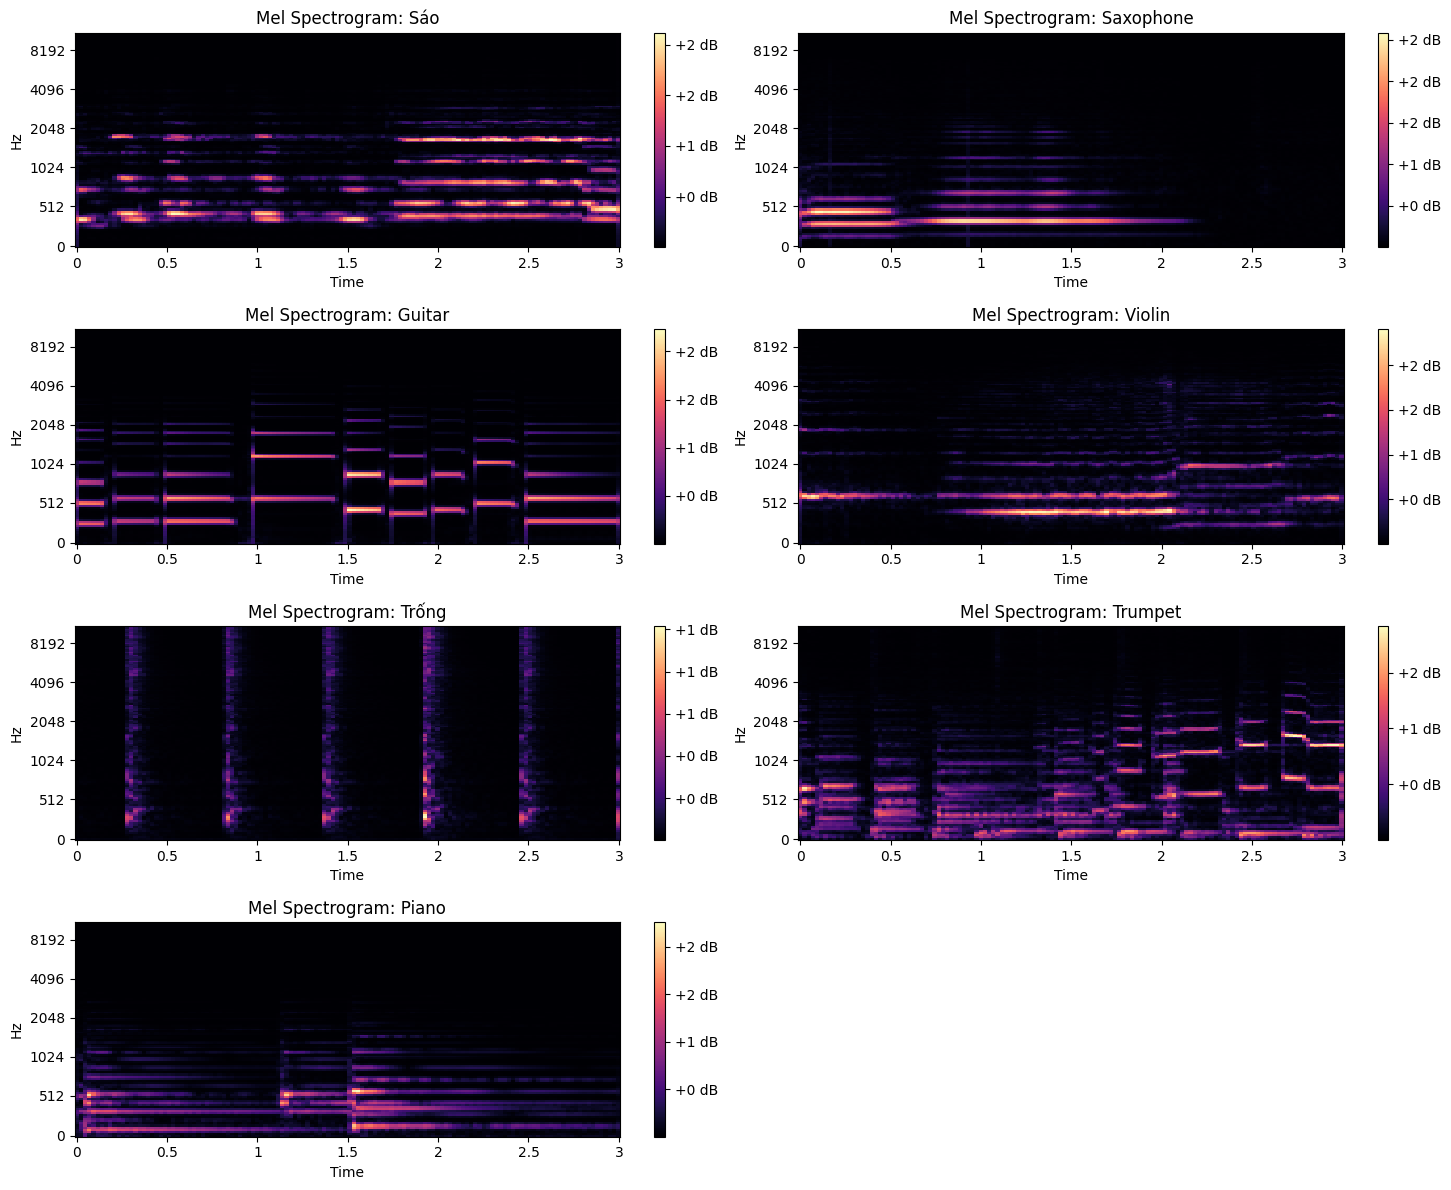

In [ ]:
visualize_mel_spectrograms(mel_specs, instruments)

In [ ]:
def mel_spectro_label(file_path, folder_path, label):
  path = os.path.join(folder_path, file_path)
  with h5py.File(path, "r") as hf:
    keys = list(hf.keys())[:5]
    mel_specs = []
    for key in keys:
      mel_spec = hf[key][:]
      mel_specs.append(mel_spec)

  new_path = os.path.join(folder_path, file_path + "labeling")
  with h5py.File(new_path, "w") as hf_label:
    hf.create_dtaset("mel_specs", data=mel_specs)
    labels = np.array([label] * len(mel_specs))
    hf.create_dtaset("labels", data=labels)

In [ ]:
mel_spectro_label("mel_spectrogram_sao_final.h5", folder_path, 0)
mel_spectro_label("mel_spectrogram_trumpet_final.h5", folder_path, 1)
mel_spectro_label("mel_spectrogram_guitar_final.h5", folder_path, 2)
mel_spectro_label("mel_spectrogram_saxo_final.h5", folder_path, 3)
mel_spectro_label("mel_spectrogram_piano_final.h5", folder_path, 4)
mel_spectro_label("mel_spectrogram_trong_final.h5", folder_path, 5)
mel_spectro_label("mel_spectrogram_violin_final.h5", folder_path, 6)